In [0]:
from torchvision import datasets, transforms
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.patches as patches
from skimage.draw import random_shapes

In [0]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu' )

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Homework 2, part 2

1. below you will find a dataloader for the cats dataset (link to dataset file on the course website)

2. the function to add noise to the dataset is built into the dataloader

3. build a model that takes in the 256x256 image, and outputs an image of the same size 

4. use the nn.MSELoss() function

5. train the network

6. submit when you feel your network is doing a decent job at cleaning the images (remember to submit both model weights and source code)

In [0]:
dir_path = 'drive/My Drive/Colab Notebooks/HW2'

In [0]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


class CustomDataset(Dataset):
    def __init__(self, path, start_idx, end_idx):

        self.data = np.load(path)
        self.data = self.data[start_idx:end_idx]

    def __len__(self):
       
        return len(self.data)
    
    def add_noise(self,y):
        newimg = random_shapes((256, 256),min_shapes=30,max_shapes=42,
                       multichannel=False, min_size=20,max_size=30,allow_overlap=True)[0]/255.0
        x = y.copy()
        x[np.where(newimg < 0.9)] = x[np.where(newimg < 0.9)]+1-newimg[newimg < 0.9]
        return x

    def __getitem__(self, idx):

        y = self.data[idx]

        x = torch.FloatTensor(self.add_noise(y)).unsqueeze(0)
        # x = x.repeat(3, 1, 1)

        return x, torch.FloatTensor(y).unsqueeze(0)

In [0]:
data_path = os.path.join(dir_path, 'cats.npy')
train_ds = CustomDataset(data_path, 0, 800)
valid_ds = CustomDataset(data_path, 800, 1000)

In [0]:
x, y = train_ds[66]

In [9]:
x.shape

torch.Size([1, 256, 256])

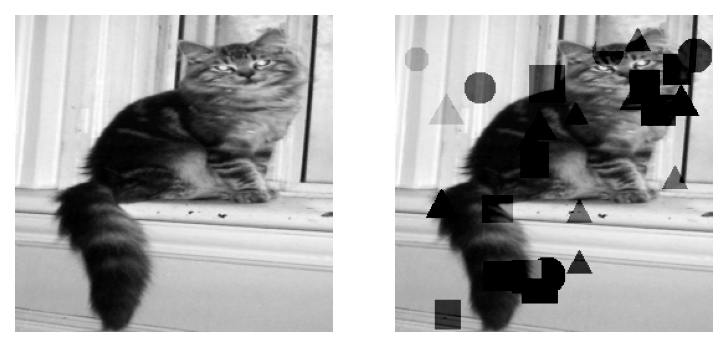

In [10]:
fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

ax[0].imshow(y[0],cmap='gist_yarg',vmin=0,vmax=1)
ax[1].imshow(x[0],cmap='gist_yarg',vmin=0,vmax=1)

for i in range(2):
    ax[i].set_axis_off()

plt.show()

In [0]:
conv_layer = nn.Conv2d(1, 512, 5, padding=2)

In [12]:
batch_of_one = x.unsqueeze(0)

batch_of_one.shape

torch.Size([1, 1, 256, 256])

In [13]:
conv_layer(batch_of_one).shape

torch.Size([1, 512, 256, 256])

In [0]:
class Denoise(nn.Module):

    def __init__(self, n_in=1):
        super(Denoise, self).__init__()
        self.n_in  = n_in
        self.filters1 = 128
        self.filters2 = 256
        self.filters3 = 512
        self.filters4 = 800
        self.filters5 = 1000

        self.conv = nn.Sequential(
              nn.Conv2d(1, self.filters1, 5, padding=2),
              nn.ReLU(),
              nn.Conv2d(self.filters1, self.filters2, 5, padding=2),
              nn.ReLU(),
              nn.Conv2d(self.filters2, self.filters3, 3, padding=1),
              nn.ReLU(),
              nn.Conv2d(self.filters3, self.filters4, 5, padding=2),
              nn.ReLU(),
              nn.Conv2d(self.filters4, self.filters5, 3, padding=1),
              nn.ReLU(),
              nn.Conv2d(self.filters5, self.n_in, 5, padding=2)
                                )

    def forward(self, x):
        out = self.conv(x)
        return out


In [15]:
model = Denoise()
if torch.cuda.is_available():
    model.cuda()
    print('cuda')

cuda


In [0]:
import torch.optim as optim 

loss_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 

In [0]:
tranining_tensor = torch.stack([train_ds[i][0] for i in range(len(train_ds))])
training_labels = torch.stack([train_ds[i][1] for i in range(len(train_ds))])

validation_tensor = torch.stack([valid_ds[i][0] for i in range(len(valid_ds))])
validation_labels = torch.stack([valid_ds[i][1] for i in range(len(valid_ds))])

batch_size = 4
training_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=batch_size)


In [0]:
from tqdm.notebook import tqdm

n_epochs = 10
n_training = len(train_ds)

loss_vs_epoch = []

for epoch in tqdm(range(n_epochs)):

    loss_array, n_correct_array = [], []
    model.train()
    for ind, (x, y) in enumerate(training_dataloader):
        optimizer.zero_grad()
        pred = model(x.to(device))   
        loss = loss_func(pred, y.to(device))    
        loss_array.append(loss.item())
        loss.backward()
        optimizer.step()
        print(f'\r epoch {epoch} - loss: {sum(loss_array)/len(loss_array):.3f}, progression: {100*ind/len(training_dataloader):.1f}%', end='')

    train_loss = sum(loss_array)/len(loss_array)

    model.eval()
    with torch.no_grad():
        for x, y in training_dataloader:
            pred = model(x.to(device))   
            loss = loss_func(pred, y.to(device))    
            loss_array.append(loss.item())

    valid_loss = sum(loss_array)/len(loss_array)

    loss_vs_epoch.append([train_loss, valid_loss])

loss_vs_epoch


 epoch 0 - loss: 0.145, progression: 4.0%

In [0]:
x, y = valid_ds[120]

fig,ax = plt.subplots(2,3,figsize=(6,(6/3)*2),dpi=250)

net.cpu()
net.eval()

input_img = x[0]
model_pred = net(x.unsqueeze(0))[0].cpu().data.numpy()[0]

ground_truth = y[0]

patch_xy = [80,100]
patch_hw = [100,100]


ax[0][0].set_title('Input',fontsize=12)
ax[0][1].set_title('Model Output',fontsize=12)
ax[0][2].set_title('Target',fontsize=12)

ax[0][0].imshow(input_img,cmap='gist_yarg',vmin=0,vmax=1)
ax[0][1].imshow(model_pred,cmap='gist_yarg',vmin=0,vmax=1)
ax[0][2].imshow(ground_truth,cmap='gist_yarg',vmin=0,vmax=1)


for i in range(0,3):
    rect = patches.Rectangle(patch_xy,patch_hw[0],patch_hw[1],linewidth=1,edgecolor='r',facecolor='none')
    ax[0][i].add_patch(rect)


input_img    = input_img[patch_xy[1]:patch_xy[1]+patch_hw[1],patch_xy[0]:patch_xy[0]+patch_hw[0]] 
model_pred   = model_pred[patch_xy[1]:patch_xy[1]+patch_hw[1],patch_xy[0]:patch_xy[0]+patch_hw[0]]    
ground_truth = ground_truth[patch_xy[1]:patch_xy[1]+patch_hw[1],patch_xy[0]:patch_xy[0]+patch_hw[0]] 


ax[1][0].imshow(input_img,cmap='gist_yarg',vmin=0,vmax=1)
ax[1][1].imshow(model_pred,cmap='gist_yarg',vmin=0,vmax=1)
ax[1][2].imshow(ground_truth,cmap='gist_yarg',vmin=0,vmax=1)


for i in range(3):
    for j in range(2):
        ax[j][i].set_axis_off()

plt.tight_layout()
plt.show()